In [1]:
from pathlib import Path
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))

BASE_DIR = Path().resolve().parent

DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"

LOG_PRC_PATH = PROCESSED_DIR / "log_prc.pkl"
MART_PRC_PATH = PROCESSED_DIR / "mart_prc.pkl"
TPS_PRC_PATH = PROCESSED_DIR / "tps_prc.pkl"




In [2]:
log = pd.read_pickle(LOG_PRC_PATH)
mart = pd.read_pickle(MART_PRC_PATH)
tps = pd.read_pickle(TPS_PRC_PATH)


pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  

In [3]:
log_base = log[['sha2_hash', 'asset','disp_rtm_sec', 'strt_dt', 'use_tms']]
mart_base = mart[['full_asset_id','asset_prod','genre']]


In [4]:
log_mart = log_base.merge(
    mart_base,
    left_on='asset',
    right_on='full_asset_id',
    how='left'
).drop(columns=['full_asset_id'])  

In [5]:
log_mart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50804389 entries, 0 to 50804388
Data columns (total 7 columns):
 #   Column        Dtype   
---  ------        -----   
 0   sha2_hash     category
 1   asset         object  
 2   disp_rtm_sec  Int64   
 3   strt_dt       int64   
 4   use_tms       Int64   
 5   asset_prod    category
 6   genre         category
dtypes: Int64(2), category(3), int64(1), object(1)
memory usage: 1.9+ GB


In [6]:
log_mart.head(4)

,sha2_hash,asset,disp_rtm_sec,strt_dt,use_tms,asset_prod,genre
0,992c0dd6bafc5df33e86ece4885d574d25288d06530c65...,cjc|M4767613LSGK41566601,61,202301,3660,RVOD,드라마
1,ea62338ac5b6b11cf02ef8bf1889d1a063cec2c2493937...,cjc|M5140475LSGL08601501,111,202301,2,RVOD,코미디
2,36aa302f3705794f5c2e5a971f38c8ef3c5a789e915c94...,cjc|M5079740LSVK14589601,74,202301,7,SVOD,공포/스릴러
3,d1ff76342bbc4f23f82c318b1f7a0ffc78f0b5ad2d1314...,cjc|M4574740LFOL08934201,1,202301,60,FOD,기타


In [ ]:
# RVOD + 10초 이상 시청만 대상
rvod_log = log_mart[
    (log_mart['asset_prod'] == 'RVOD') &
    (log_mart['use_tms'] >= 10)
].copy()
# 연 / 월 분리
rvod_log['year'] = rvod_log['strt_dt'] // 100
rvod_log['month'] = rvod_log['strt_dt'] % 100

# 3개월 단위(분기)
rvod_log['quarter'] = ((rvod_log['month'] - 1) // 3) + 1

# 3개월 키
rvod_log['year_quarter'] = (
    rvod_log['year'].astype(str) + 'Q' + rvod_log['quarter'].astype(str)
)
user_quarter_rvod_summary = (
    rvod_log
    .groupby(['sha2_hash', 'year_quarter'])
    .agg(
        rvod_purchase_count=(
            'asset',
            'count'     
        ),
        rvod_genre_list=(
            'genre',
            lambda x: list(x.dropna().unique())
        )
    )
    .reset_index()
)



C:\Users\dkswn\AppData\Local\Temp\ipykernel_7240\645138846.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sha2_hash', 'year_quarter'])


In [8]:
log_mart = log_mart.copy()

log_mart['year'] = log_mart['strt_dt'] // 100
log_mart['month'] = log_mart['strt_dt'] % 100
log_mart['quarter'] = ((log_mart['month'] - 1) // 3) + 1

log_mart['year_quarter'] = (
    log_mart['year'].astype(str) + 'Q' + log_mart['quarter'].astype(str)
)


In [9]:
log_mart = log_mart.merge(
    user_quarter_rvod_summary,
    on=['sha2_hash', 'year_quarter'],
    how='left'
)

In [10]:
log_mart.head(3)

,sha2_hash,asset,disp_rtm_sec,strt_dt,use_tms,asset_prod,genre,year,month,quarter,year_quarter,rvod_purchase_count,rvod_genre_list
0,992c0dd6bafc5df33e86ece4885d574d25288d06530c65...,cjc|M4767613LSGK41566601,61,202301,3660,RVOD,드라마,2023,1,1,2023Q1,534,"[드라마, 연예/오락, 미니시리즈]"
1,ea62338ac5b6b11cf02ef8bf1889d1a063cec2c2493937...,cjc|M5140475LSGL08601501,111,202301,2,RVOD,코미디,2023,1,1,2023Q1,4,"[애니메이션, 코미디]"
2,36aa302f3705794f5c2e5a971f38c8ef3c5a789e915c94...,cjc|M5079740LSVK14589601,74,202301,7,SVOD,공포/스릴러,2023,1,1,2023Q1,18,"[연예오락, 액션/어드벤쳐]"


In [11]:
sample_user = log_mart['sha2_hash'].iloc[0]
log_mart_user = log_mart[
    log_mart['sha2_hash'] == sample_user
].sort_values('year_quarter')
log_mart_user[['sha2_hash', 'year_quarter']].drop_duplicates()



,sha2_hash,year_quarter
0,992c0dd6bafc5df33e86ece4885d574d25288d06530c65...,2023Q1
22852741,992c0dd6bafc5df33e86ece4885d574d25288d06530c65...,2023Q2


In [ ]:
import pandas as pd

# =====================================================
# 1. 에로틱 시청 고객 정의 (10초 이상)
# =====================================================
erotic_users = (
    log_mart[
        (log_mart['genre'] == '에로틱') &
        (log_mart['use_tms'] >= 10)
    ]['sha2_hash']
    .drop_duplicates()
)

# =====================================================
# 2. 고객 단위 RVOD 구매/시청 집계
# =====================================================
user_rvod_summary = (
    log_mart[log_mart['asset_prod'] == 'RVOD']
    .groupby('sha2_hash')
    .agg(
        rvod_count=('asset_prod', 'count'),
        rvod_time=('use_tms', 'sum')
    )
    .reset_index()
)

# =====================================================
# 3. 전체 고객 기준으로 맞추기 (RVOD 미구매자 포함)
# =====================================================
all_users = pd.DataFrame(
    {'sha2_hash': log_mart['sha2_hash'].unique()}
)

user_rvod_summary = (
    all_users
    .merge(user_rvod_summary, on='sha2_hash', how='left')
)

user_rvod_summary[['rvod_count', 'rvod_time']] = (
    user_rvod_summary[['rvod_count', 'rvod_time']]
    .fillna(0)
)

# =====================================================
# 4. 에로틱 시청 여부 플래그
# =====================================================
user_rvod_summary['erotic_viewer'] = (
    user_rvod_summary['sha2_hash']
    .isin(erotic_users)
    .astype(int)
)

# =====================================================
# 5. RVOD 구매 여부 플래그
# =====================================================
user_rvod_summary['rvod_buyer'] = (
    user_rvod_summary['rvod_count'] > 0
).astype(int)

# =====================================================
# 6. 에로틱 시청 여부별 RVOD 구매 비교
# =====================================================
comparison = (
    user_rvod_summary
    .groupby('erotic_viewer')
    .agg(
        user_cnt=('sha2_hash', 'count'),
        avg_rvod_count=('rvod_count', 'mean'),
        avg_rvod_time=('rvod_time', 'mean'),
        rvod_buyer_ratio=('rvod_buyer', 'mean')
    )
    .reset_index()
)

# =====================================================
# 7. RVOD 구매 횟수 구간화 
# =====================================================
def rvod_bucket(x):
    if x == 0:
        return '0회'
    elif x == 1:
        return '1회'
    elif 2 <= x <= 4:
        return '2~4회'
    else:
        return '5회 이상'


comparison


C:\Users\dkswn\AppData\Local\Temp\ipykernel_7240\2176529313.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('sha2_hash')


,erotic_viewer,user_cnt,avg_rvod_count,avg_rvod_time,rvod_buyer_ratio
0,0,610793,17.622384,33260.329102,0.371003
1,1,206325,31.073035,51954.234514,0.412475


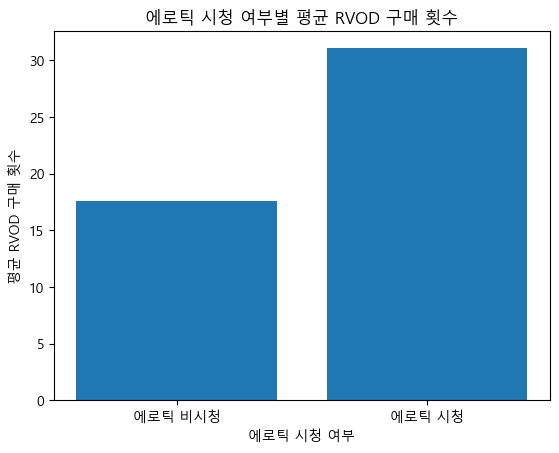

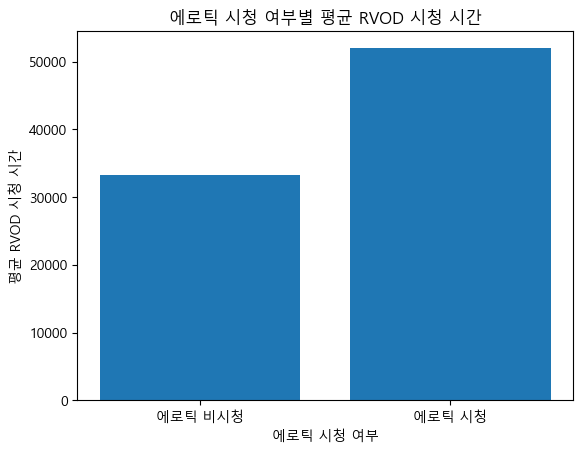

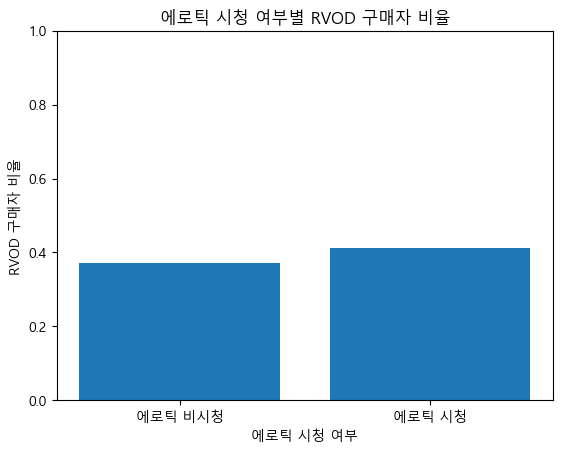

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  
plt.rcParams['axes.unicode_minus'] = False   

comparison['erotic_label'] = comparison['erotic_viewer'].map({
    0: '에로틱 비시청',
    1: '에로틱 시청'
})

# 1️⃣ 평균 RVOD 구매 횟수
plt.figure()
plt.bar(comparison['erotic_label'], comparison['avg_rvod_count'])
plt.xlabel('에로틱 시청 여부')
plt.ylabel('평균 RVOD 구매 횟수')
plt.title('에로틱 시청 여부별 평균 RVOD 구매 횟수')
plt.show()

# 2️⃣ 평균 RVOD 시청 시간
plt.figure()
plt.bar(comparison['erotic_label'], comparison['avg_rvod_time'])
plt.xlabel('에로틱 시청 여부')
plt.ylabel('평균 RVOD 시청 시간')
plt.title('에로틱 시청 여부별 평균 RVOD 시청 시간')
plt.show()

# 3️⃣ RVOD 구매자 비율
plt.figure()
plt.bar(comparison['erotic_label'], comparison['rvod_buyer_ratio'])
plt.xlabel('에로틱 시청 여부')
plt.ylabel('RVOD 구매자 비율')
plt.title('에로틱 시청 여부별 RVOD 구매자 비율')
plt.ylim(0, 1)
plt.show()


In [ ]:
user_rvod_summary['rvod_bucket'] = (
    user_rvod_summary['rvod_count']
    .apply(rvod_bucket)
)

# =====================================================
# 8. 구매 횟수 구간별 에로틱 시청 비율 & 구매 강도
# =====================================================
rvod_bucket_analysis = (
    user_rvod_summary
    .groupby('rvod_bucket')
    .agg(
        user_cnt=('sha2_hash', 'count'),
        erotic_viewer_ratio=('erotic_viewer', 'mean'),
        avg_rvod_count=('rvod_count', 'mean'),
        avg_rvod_time=('rvod_time', 'mean')
    )
    .reset_index()
    .sort_values('rvod_bucket')
)

rvod_bucket_analysis


,rvod_bucket,user_cnt,erotic_viewer_ratio,avg_rvod_count,avg_rvod_time
0,0회,505408,0.239848,0.000000,0.0
1,1회,70336,0.211769,1.000000,3054.686732
2,2~4회,89668,0.236093,2.759636,6818.233004
3,5회 이상,151706,0.323250,111.116146,199124.634925


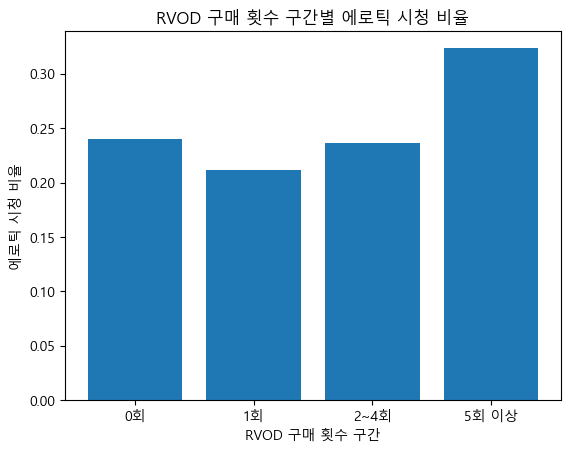

In [ ]:
 
rvod_bucket_plot = (
    user_rvod_summary
    .groupby('rvod_bucket')
    .agg(
        erotic_viewer_ratio=('erotic_viewer', 'mean')
    )
    .reset_index()
)

plt.figure()
plt.bar(
    rvod_bucket_plot['rvod_bucket'],
    rvod_bucket_plot['erotic_viewer_ratio']
)
plt.xlabel('RVOD 구매 횟수 구간')
plt.ylabel('에로틱 시청 비율')
plt.title('RVOD 구매 횟수 구간별 에로틱 시청 비율')
plt.show()
